<a href="https://colab.research.google.com/github/candiceevemiller/personal-projects/blob/main/Cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def unpickle(file):
  with open(file, 'rb') as fo:
    myDict = pickle.load(fo, encoding='latin1')
  return myDict

In [ ]:
tf.random.set_seed(42)

trainData = unpickle('train')

for item in trainData:
  print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [ ]:
len(trainData['data'])

50000

In [ ]:
len(trainData['data'][0])

3072

In [ ]:
testData = unpickle('test')

metaData = unpickle('meta')
print('Fine labels:', metaData['fine_label_names'])

Fine labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

In [ ]:
categories = pd.DataFrame(metaData['fine_label_names'],columns=['subclass'])
categories['superclass'] = pd.DataFrame(metaData['coarse_label_names'])
print(categories)

         subclass            superclass
0           apple       aquatic_mammals
1   aquarium_fish                  fish
2            baby               flowers
3            bear       food_containers
4          beaver  fruit_and_vegetables
..            ...                   ...
95          whale                   NaN
96    willow_tree                   NaN
97           wolf                   NaN
98          woman                   NaN
99           worm                   NaN

[100 rows x 2 columns]


In [ ]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [ ]:
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)

Image number selected: 44271
Shape of image: (32, 32, 3)
Image subclass number: 38


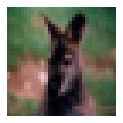

In [ ]:
rcParams['figure.figsize'] = 2,2

def show_random_image():
  imageId = np.random.randint(0,len(X_train))
  plt.imshow(X_train[imageId])
  plt.axis('off')
  print(f'Image number selected: {imageId}')
  print(f'Shape of image: {X_train[imageId].shape}')
  print(f'Image subclass number: {trainData["fine_labels"][imageId]}')

show_random_image()

In [ ]:
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)

y_train_fine = trainData['fine_labels']
y_train_coarse = trainData['coarse_labels']
y_test_fine = testData['fine_labels']
y_test_coarse = testData['coarse_labels']

In [ ]:
NUM_CLASSES = 100
NUM_SUPERCLASSES = 20

y_train_fine = to_categorical(y_train_fine, NUM_CLASSES)
y_train_coarse = to_categorical(y_train_coarse, NUM_SUPERCLASSES)
y_test_fine = to_categorical(y_test_fine, NUM_CLASSES)
y_test_coarse = to_categorical(y_test_coarse, NUM_SUPERCLASSES)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2)

for train_index, val_index in sss.split(X_train, y_train_fine, y_train_coarse):
  X_train_data, X_val_data = X_train[train_index], X_train[val_index]
  y_train_coarse_data, y_val_coarse_data = y_train_coarse[train_index], y_train_coarse[val_index]
  y_train_fine_data, y_val_fine_data = y_train_fine[train_index], y_train_fine[val_index]

print('Number of training samples:', X_train_data.shape[0])
print('Number of validation samples:', X_val_data.shape[0])

Number of training samples: 40000
Number of validation samples: 10000


In [ ]:
from tensorflow.keras import layers

model = keras.Sequential([
  layers.Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.2),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.2),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3),kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Conv2D(128, (3,3),kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.2),
  layers.BatchNormalization(),
  layers.Flatten(),
  layers.Dense(128, kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.Activation('swish'),
  layers.AlphaDropout(0.2),
  layers.Dense(128, kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.Activation('swish'),
  layers.AlphaDropout(0.2),
  layers.Dense(20, activation='softmax'),
])

In [ ]:
INIT_LR = 5e-3
BATCH_SIZE = 128
EPOCHS = 200

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR), metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('cifar100CNN.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_data, y_train_coarse_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_data, y_val_coarse_data),
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/200
313/313 [==============================] - 6s 15ms/step - loss: 3.1944 - accuracy: 0.1933 - val_loss: 2.5357 - val_accuracy: 0.3160
Epoch 2/200
313/313 [==============================] - 4s 13ms/step - loss: 2.4937 - accuracy: 0.2898 - val_loss: 2.7833 - val_accuracy: 0.3586
Epoch 3/200
313/313 [==============================] - 4s 13ms/step - loss: 2.3472 - accuracy: 0.3345 - val_loss: 2.4590 - val_accuracy: 0.4043
Epoch 4/200
313/313 [==============================] - 4s 13ms/step - loss: 2.2491 - accuracy: 0.3705 - val_loss: 2.2684 - val_accuracy: 0.4459
Epoch 5/200
313/313 [==============================] - 4s 14ms/step - loss: 2.1774 - accuracy: 0.3948 - val_loss: 2.1779 - val_accuracy: 0.4586
Epoch 6/200
313/313 [==============================] - 4s 13ms/step - loss: 2.1222 - accuracy: 0.4106 - val_loss: 2.3009 - val_accuracy: 0.4657
Epoch 7/200
313/313 [==============================] - 4s 13ms/step - loss: 2.0674 - accuracy: 0.4341 - val_loss: 2.1299 - val_accuracy:

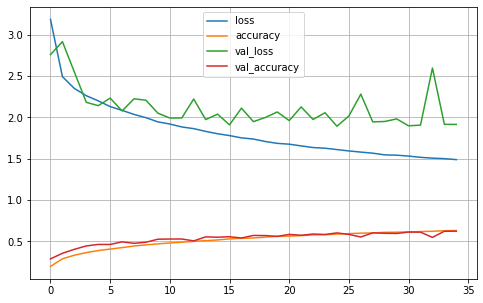

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

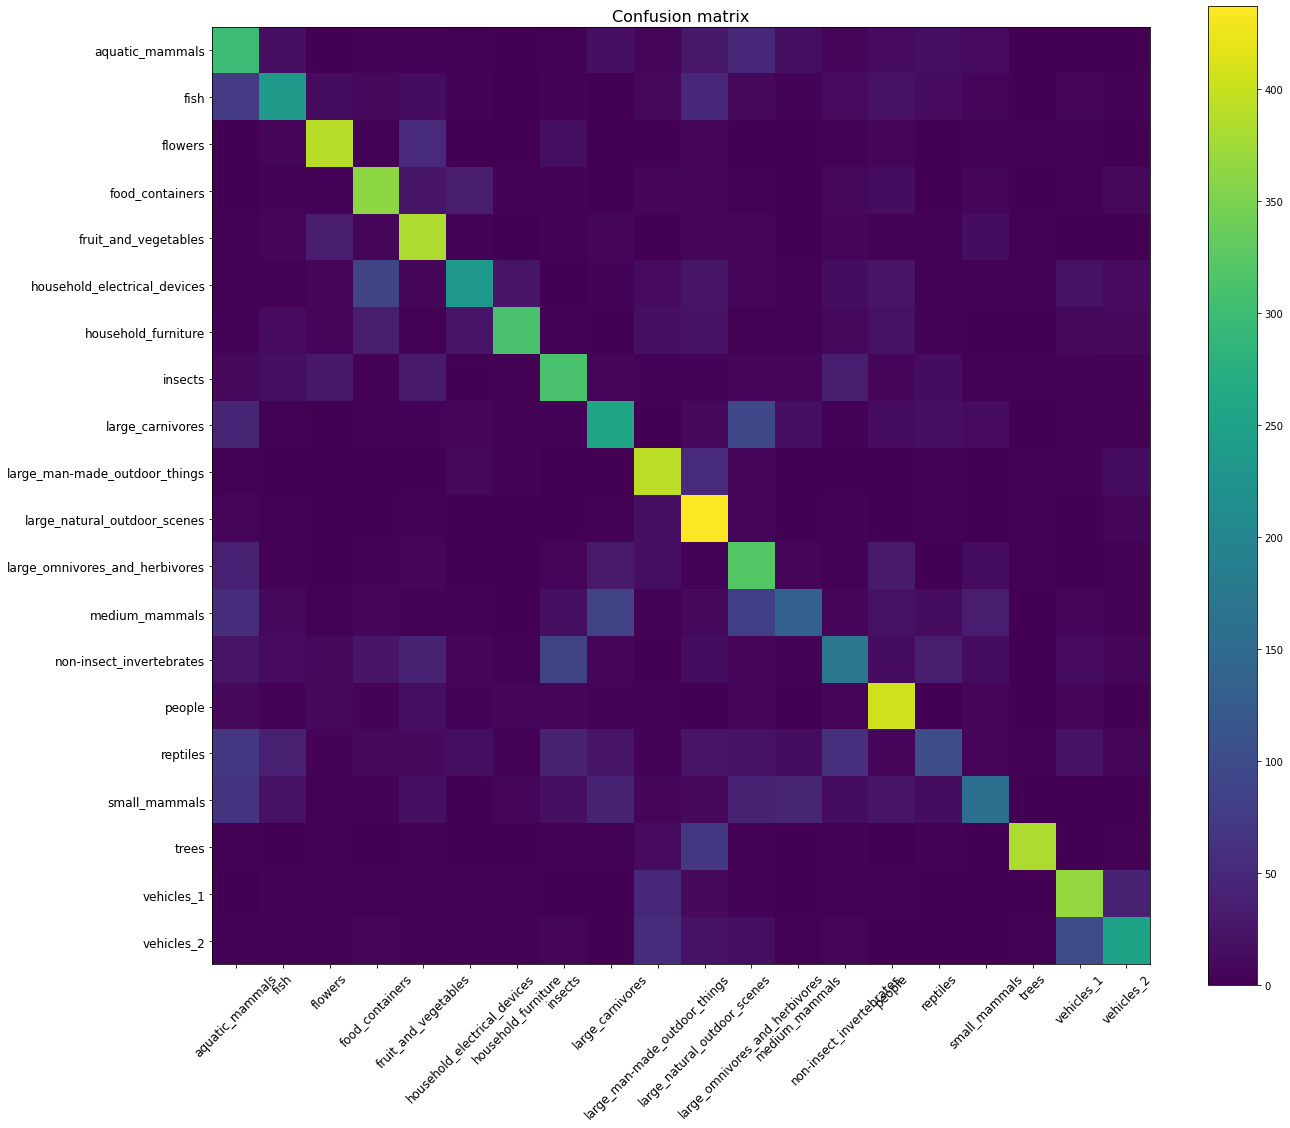

Test accuracy: 0.5918


In [ ]:
# make test predictions
y_pred_test = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = np.array([list(onehot).index(1) for onehot in y_test_coarse])

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(21, 18))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(20), categories['superclass'], rotation=45, fontsize=12)
plt.yticks(np.arange(20), categories['superclass'], fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))